In [1]:
"""
@author: Crazy Trader

Description:
    This demo shows the simple EQ Short Trading with open price, high price and low price repeatedly captured during the trading hour
    
    Open HSI Short Position with Qty 100, Long Call with Qty 20 and Short Put with Qty 20 if either one of the conditions is matched:
        - 0005.HK drops 1% from the open price
        - 0700.HK drops 1% from the open price
        - VHSI increases by 1 point
        - VIX increases by 1 point
    
    The algorithm restricts only one position per product.
    
    Close all Positions if either one of the condtions is matched:
        - VHSI decreases by 1 point
        - VIX decreases by 1 point
"""

'\n@author: Crazy Trader\n\nDescription:\n    This demo shows the simple EQ Short Trading with open price, high price and low price repeatedly captured during the trading hour\n    \n    Open HSI Short Position with Qty 100, Long Call with Qty 20 and Short Put with Qty 20 if either one of the conditions is matched:\n        - 0005.HK drops 1% from the open price\n        - 0700.HK drops 1% from the open price\n        - VHSI increases by 1 point\n        - VIX increases by 1 point\n    \n    The algorithm restricts only one position per product.\n    \n    Close all Positions if either one of the condtions is matched:\n        - VHSI decreases by 1 point\n        - VIX decreases by 1 point\n'

In [2]:
#%% Library & Initialize Dataset and Backtesting Platform
from library.functions import *
dataset = {}
dataset['0005.HK']  = 'EQ'       # Close, Volume
dataset['0700.HK']  = 'EQ'       # Close, Volume
dataset['HSI']      = 'EQ'       # Close, Volume
dataset['PUT']      = 'Custom'   # requires functions
dataset['CALL']     = 'Custom'   # requires functions
dataset['VHSI']     = 'Vol'      # Close
dataset['VIX']      = 'Vol'      # Close
dataset['USDHKD']   = 'FX'       # Bid, Ask
dataset['XAUHKD']   = 'FX'       # Bid, Ask
dataset['HKDTRY']   = 'FX'       # Bid, Ask
dataset['USDTRY']   = 'FX'       # Bid, Ask
dataset['XRPUSD']   = 'FX'       # Bid, Ask
# load dataset and setup initial cash + default handling fee
platform = backtest(10000000, 100, dataset)

Dataset 0005.HK is loaded
Dataset 0700.HK is loaded
Dataset HSI is loaded
Dataset VHSI is loaded
Dataset VIX is loaded
Dataset USDHKD is loaded
Dataset XAUHKD is loaded
Dataset HKDTRY is loaded
Dataset USDTRY is loaded
Dataset XRPUSD is loaded
Dataset Range: from 2018-08-13 09:21:00 to 2018-11-08 16:01:00


In [3]:
start   = platform.validstart                               # initialize start date
end     = platform.validend                                 # initialize start date
mask = (platform.quote['USDHKD'].index > start) & (platform.quote['USDHKD'].index <= end)
backtestperiod = platform.quote['USDHKD'].loc[mask]
platform.initportfolio(10000000, 100)                       # reset initial cash + default handling fee

In [4]:
#%% Backtesting
prev = None
openrate    = {}
highrate    = {}
lowrate     = {}

openrate['0005.HK']     = None
openrate['0700.HK']     = None
highrate['0005.HK']     = None
highrate['0700.HK']     = None
lowrate['0005.HK']      = None
lowrate['0700.HK']      = None
# start looping every 1 minute
print ('Start Backtesting...')
for time, reference in backtestperiod.iterrows():
    #Examples: 
    if not prev:                                    # skip first loop to record the time
        prev = time
        print (time, 'Avl.Cash:', platform.portfolio['cash'])
        continue
    # Check if EQ market is opened
    if platform.is_eqmktopen(time): 
        # initialize Rates
        if not openrate['0005.HK']:
            openrate['0005.HK'] = platform.quote['0005.HK'].loc[time].Close
        if not openrate['0700.HK']:
            openrate['0700.HK'] = platform.quote['0700.HK'].loc[time].Close
        if not highrate['0005.HK'] or platform.quote['0005.HK'].loc[time].Close > highrate['0005.HK']:
            highrate['0005.HK'] = platform.quote['0005.HK'].loc[time].Close
        if not highrate['0700.HK'] or platform.quote['0700.HK'].loc[time].Close > highrate['0700.HK']:
            highrate['0700.HK'] = platform.quote['0700.HK'].loc[time].Close
        if not lowrate['0005.HK'] or platform.quote['0005.HK'].loc[time].Close < lowrate['0005.HK']:
            lowrate['0005.HK']  = platform.quote['0005.HK'].loc[time].Close
        if not lowrate['0700.HK'] or platform.quote['0700.HK'].loc[time].Close < lowrate['0700.HK']:
            lowrate['0700.HK']  = platform.quote['0700.HK'].loc[time].Close
            
        # Long EQ conditions
        if (    platform.quote['0005.HK'].loc[time].Close < (openrate['0005.HK'] + 0.01 * openrate['0005.HK']) # Drop 1%
             or platform.quote['0700.HK'].loc[time].Close < (openrate['0700.HK'] + 0.01 * openrate['0700.HK']) # Drop 1%
             or platform.quote['VHSI'].loc[time].Close - platform.quote['VHSI'].loc[prev].Close >= 1 
             or platform.quote['VIX'].loc[time].Close - platform.quote['VIX'].loc[prev].Close >= 1
             ):
            if not platform.has_pos('HSI'):                     # Check if no position exists
                platform.trade(time, 'HSI',  'SHORT', 100)
                option_maturity     = time.month
                option_strike       = (int(platform.quote['HSI'].loc[time].Close / 200) - 2) * 200      # option step: 200
                platform.trade(time, 'CALL', 'LONG',  20, option_strike, option_maturity)               # Hedging Falling Trend
                platform.trade(time, 'PUT', 'SHORT',  20, option_strike, option_maturity)               # Hedging Falling Trend
                
        # Close EQ conditions
        if (
                platform.quote['VHSI'].loc[prev].Close - platform.quote['VHSI'].loc[time].Close >= 1 
             or platform.quote['VIX'].loc[prev].Close - platform.quote['VIX'].loc[time].Close >= 1
             ):
            if platform.has_pos('HSI'):                         # Check if position exists
                platform.trade(time, 'HSI',  'CLOSE')
                platform.trade(time, 'CALL', 'CLOSE')
                platform.trade(time, 'PUT', 'CLOSE')
    else:
        # Reset rates to None for next day
        openrate['0005.HK']     = None
        openrate['0700.HK']     = None
        highrate['0005.HK']     = None
        highrate['0700.HK']     = None
        lowrate['0005.HK']      = None
        lowrate['0700.HK']      = None
                
    # Check if FX and Crypto markets are opened             
    if platform.is_fxmktopen(time):  
        pass
                
    prev = time                                                 # Save this time for next loop
    
    # Update position info once a day: Unrealized, realized P&L
    if time.timestamp() % 86400 == 0:
        platform.updatepos(time)

Start Backtesting...
2018-08-13 09:22:00 Avl.Cash: 10000000
2018-08-13 09:23:00 Avl.Cash: 7216300.0 HSI SHORT 100 @ 27836.0
2018-08-13 09:23:00 Avl.Cash: 7201052.0 CALL ( 27400 8 ) LONG 20 @ 757.4
2018-08-13 09:23:00 Avl.Cash: 7193651.0 PUT ( 27400 8 ) SHORT 20 @ 365.06
2018-08-31 00:00:00 Avl.Cash: 7210231.0 CALL CLOSE 20 Mature @ 28239.0
2018-08-31 00:00:00 Avl.Cash: 7224633.0 PUT CLOSE 20 Mature @ 28239.0
2018-09-13 09:31:00 Avl.Cash: 10108033.0 HSI CLOSE 100 @ 26835.0
2018-09-13 09:32:00 Avl.Cash: 7425233.0 HSI SHORT 100 @ 26827.0
2018-09-13 09:32:00 Avl.Cash: 7411457.0 CALL ( 26400 9 ) LONG 20 @ 683.78
2018-09-13 09:32:00 Avl.Cash: 7405561.0 PUT ( 26400 9 ) SHORT 20 @ 289.85
2018-09-14 13:01:00 Avl.Cash: 10051761.0 HSI CLOSE 100 @ 27189.0
2018-09-14 13:01:00 Avl.Cash: 10069878.0 CALL CLOSE 20 @ 920.85
2018-09-14 13:01:00 Avl.Cash: 10077925.0 PUT CLOSE 20 @ 162.33
2018-09-14 13:02:00 Avl.Cash: 7360325.0 HSI SHORT 100 @ 27175.0
2018-09-14 13:02:00 Avl.Cash: 7344868.0 CALL ( 26600 9 

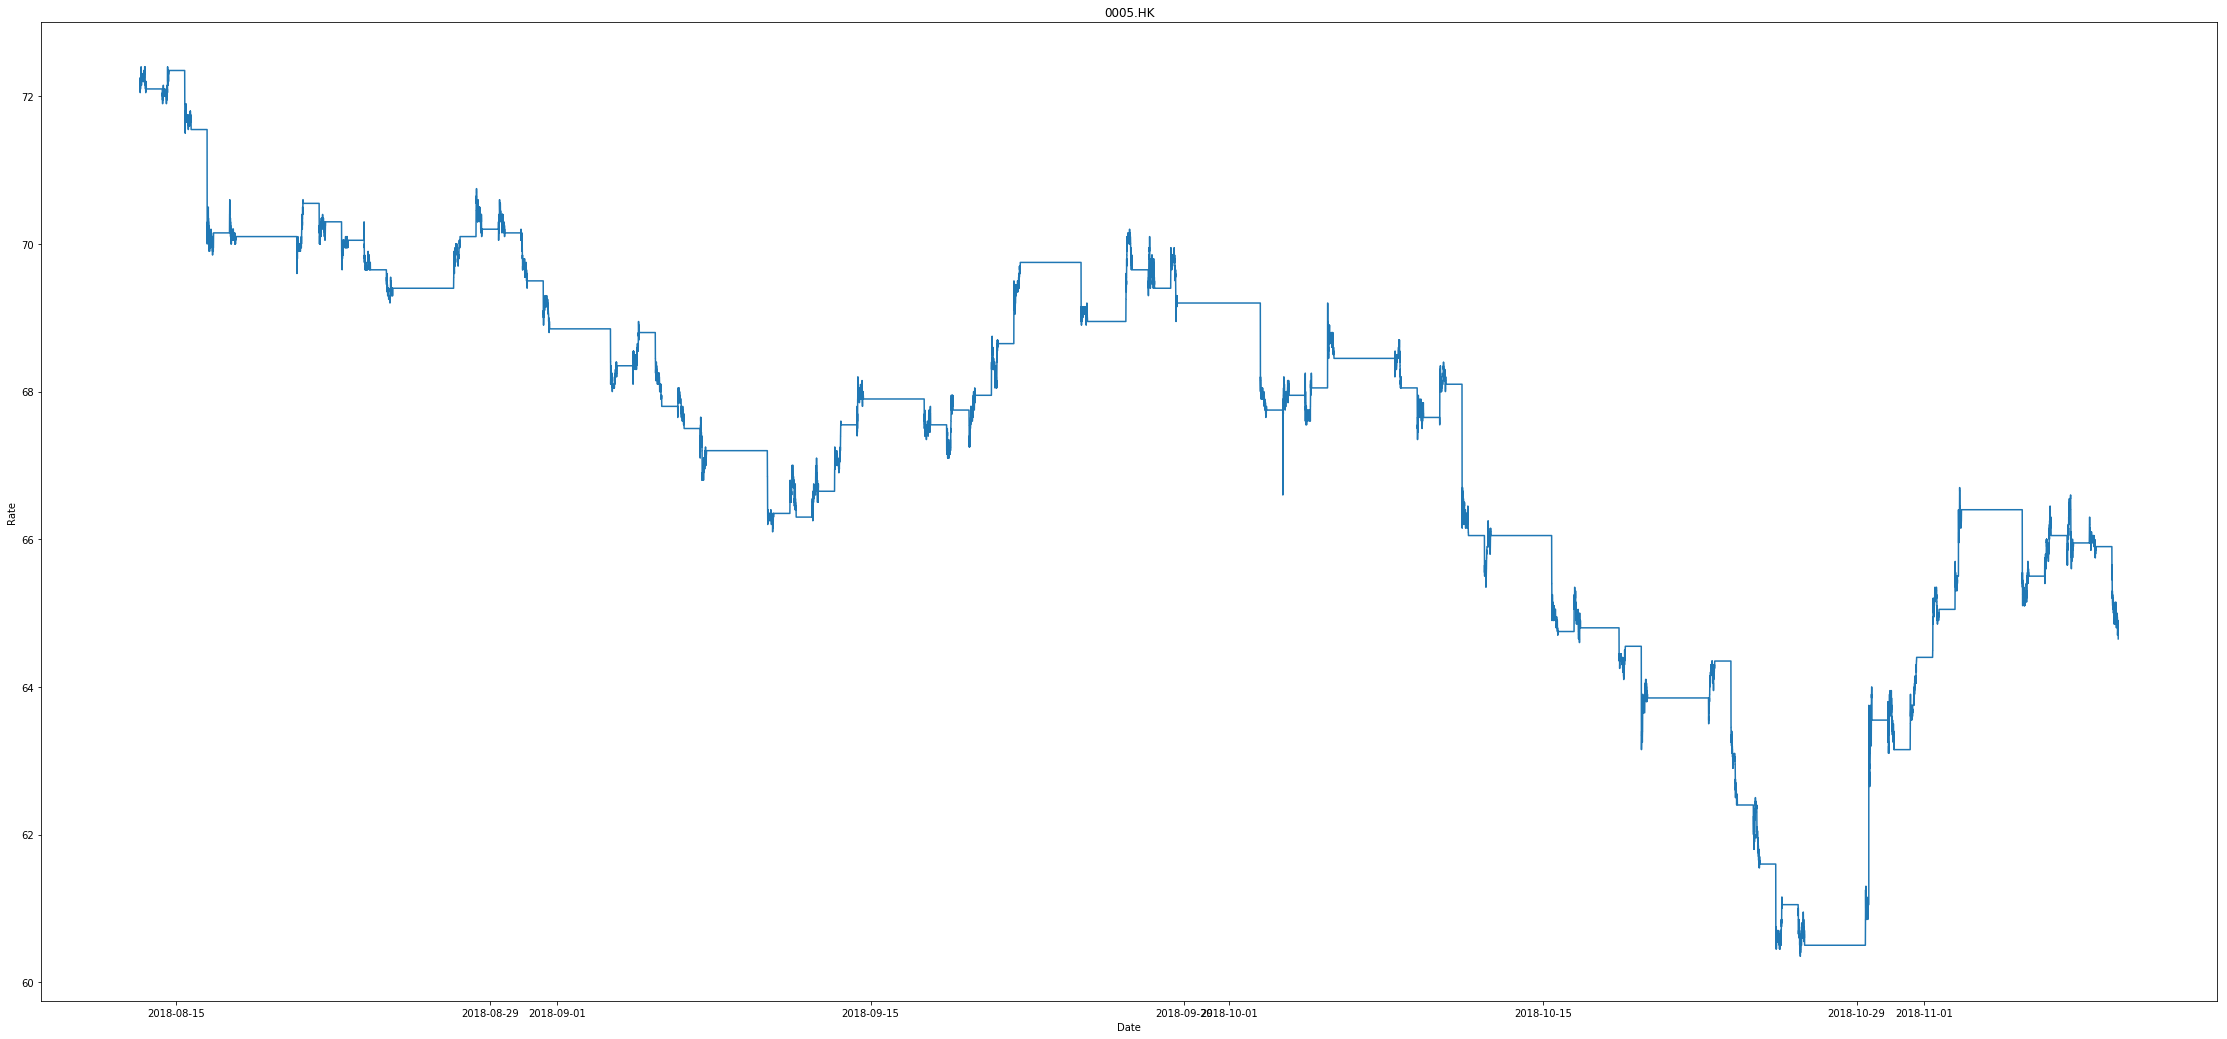

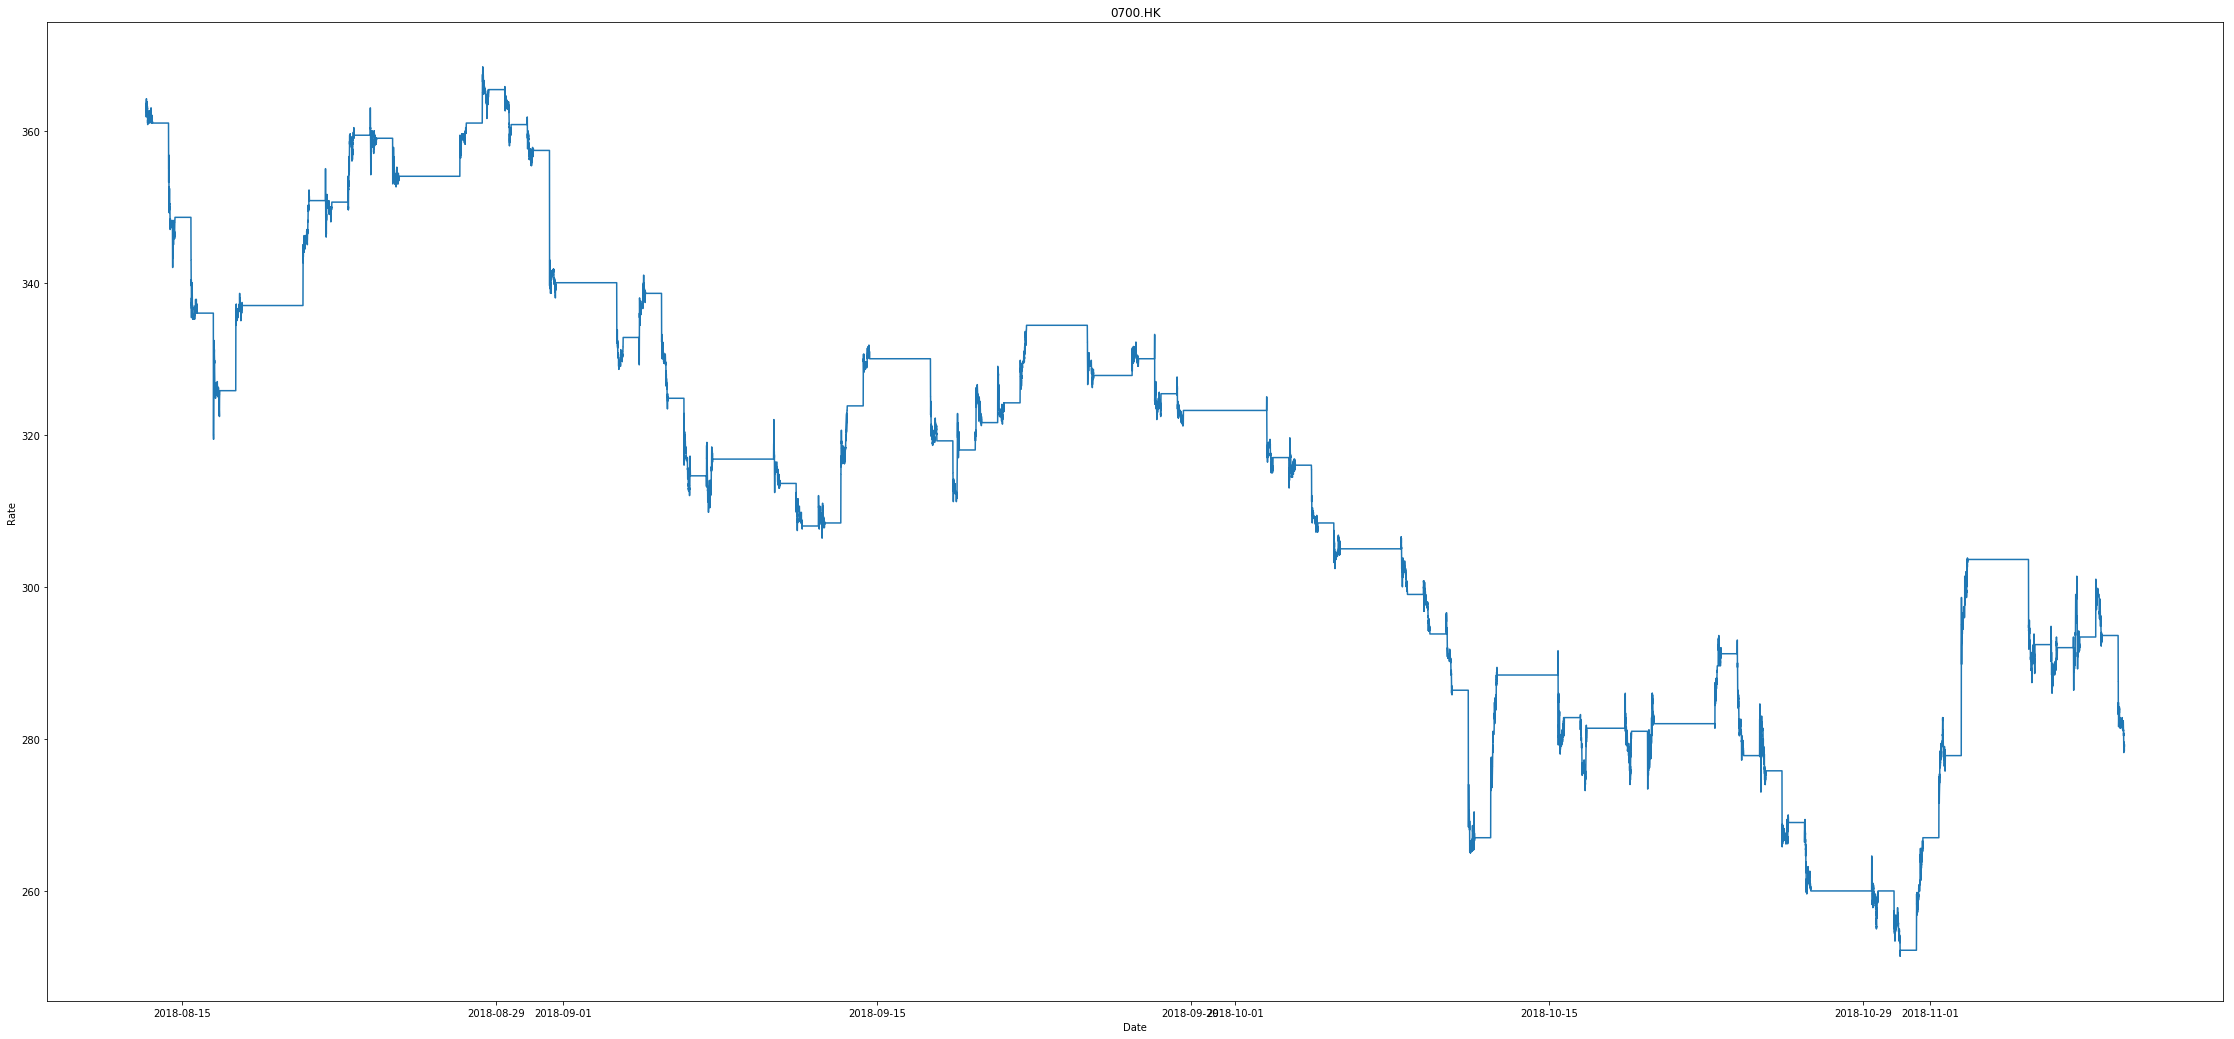

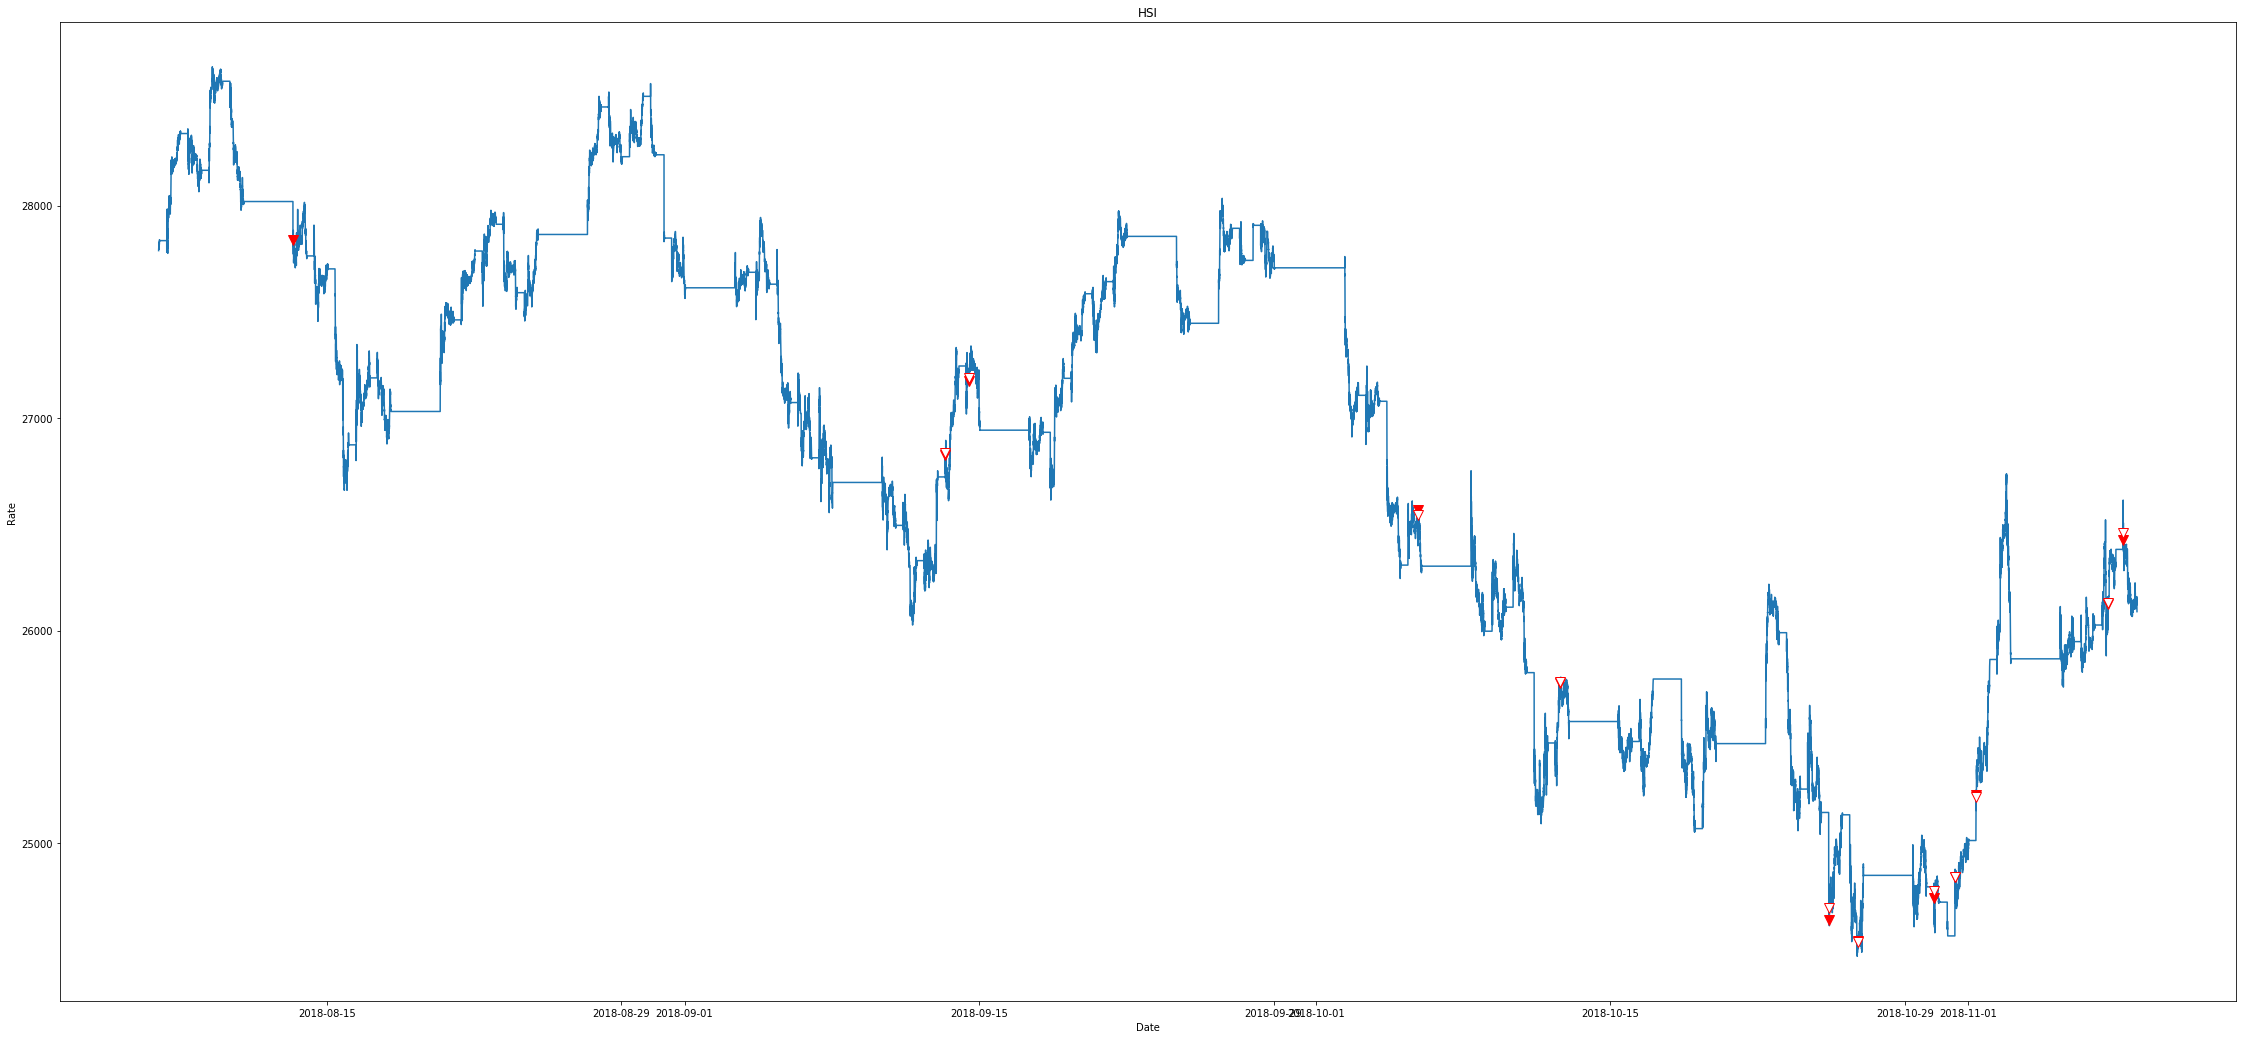

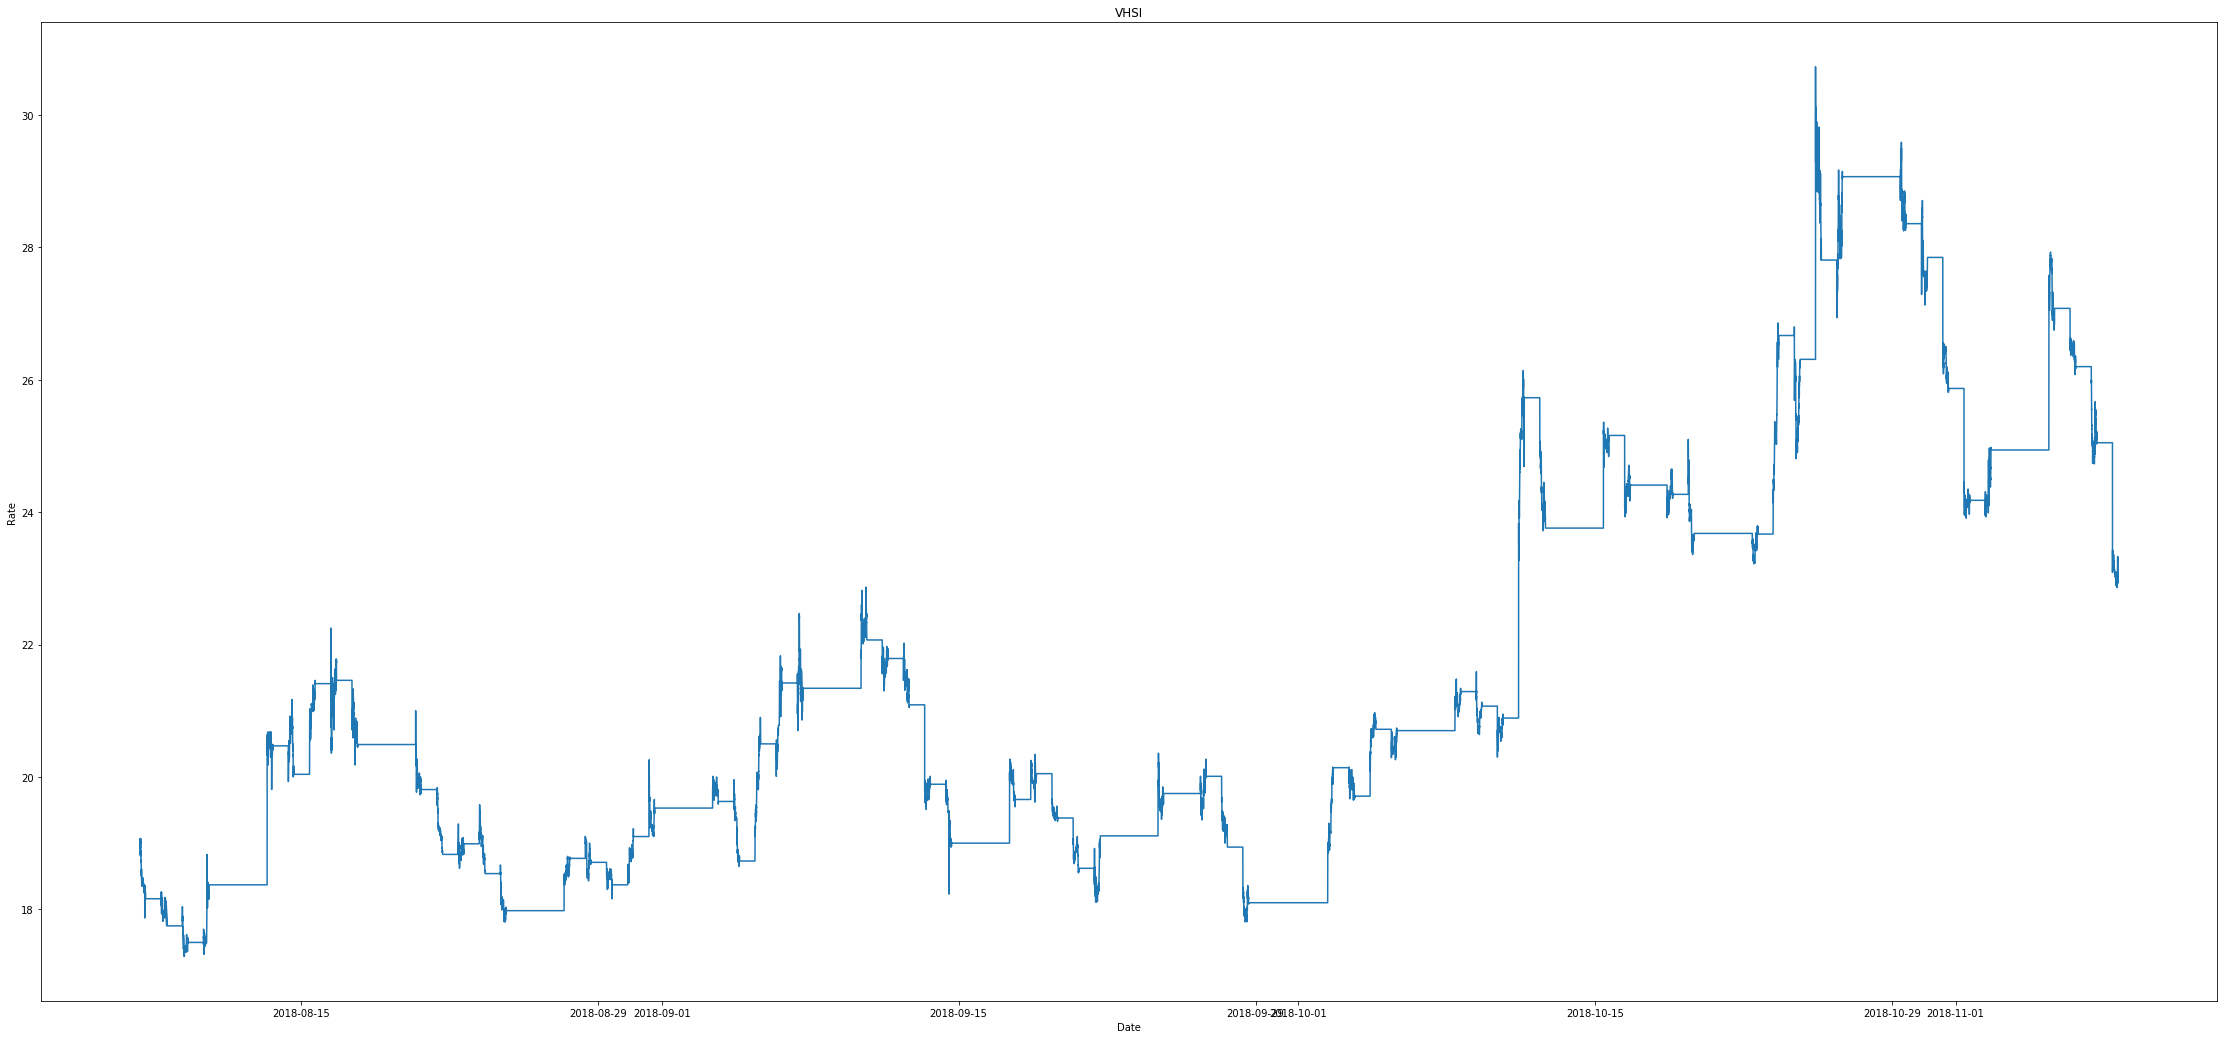

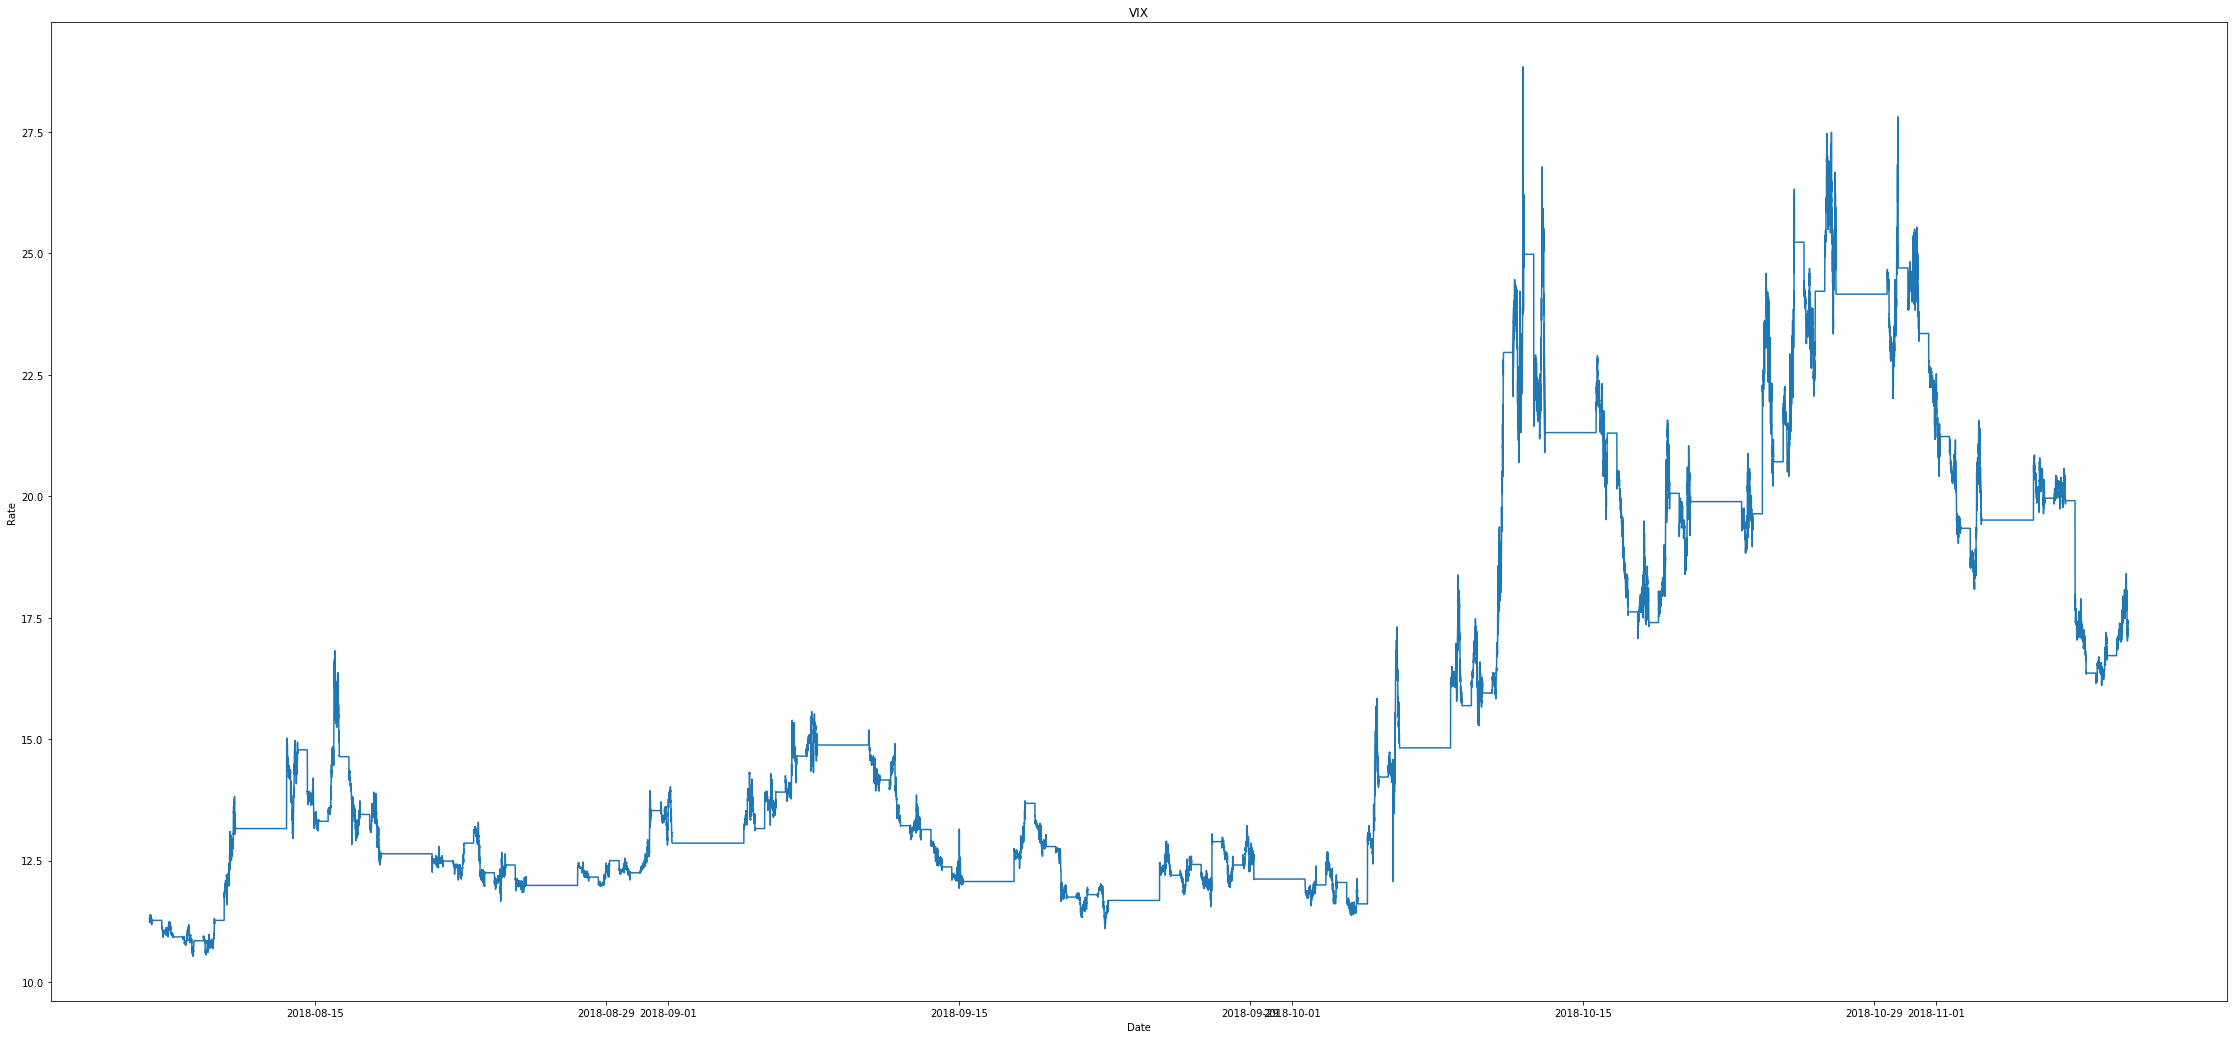

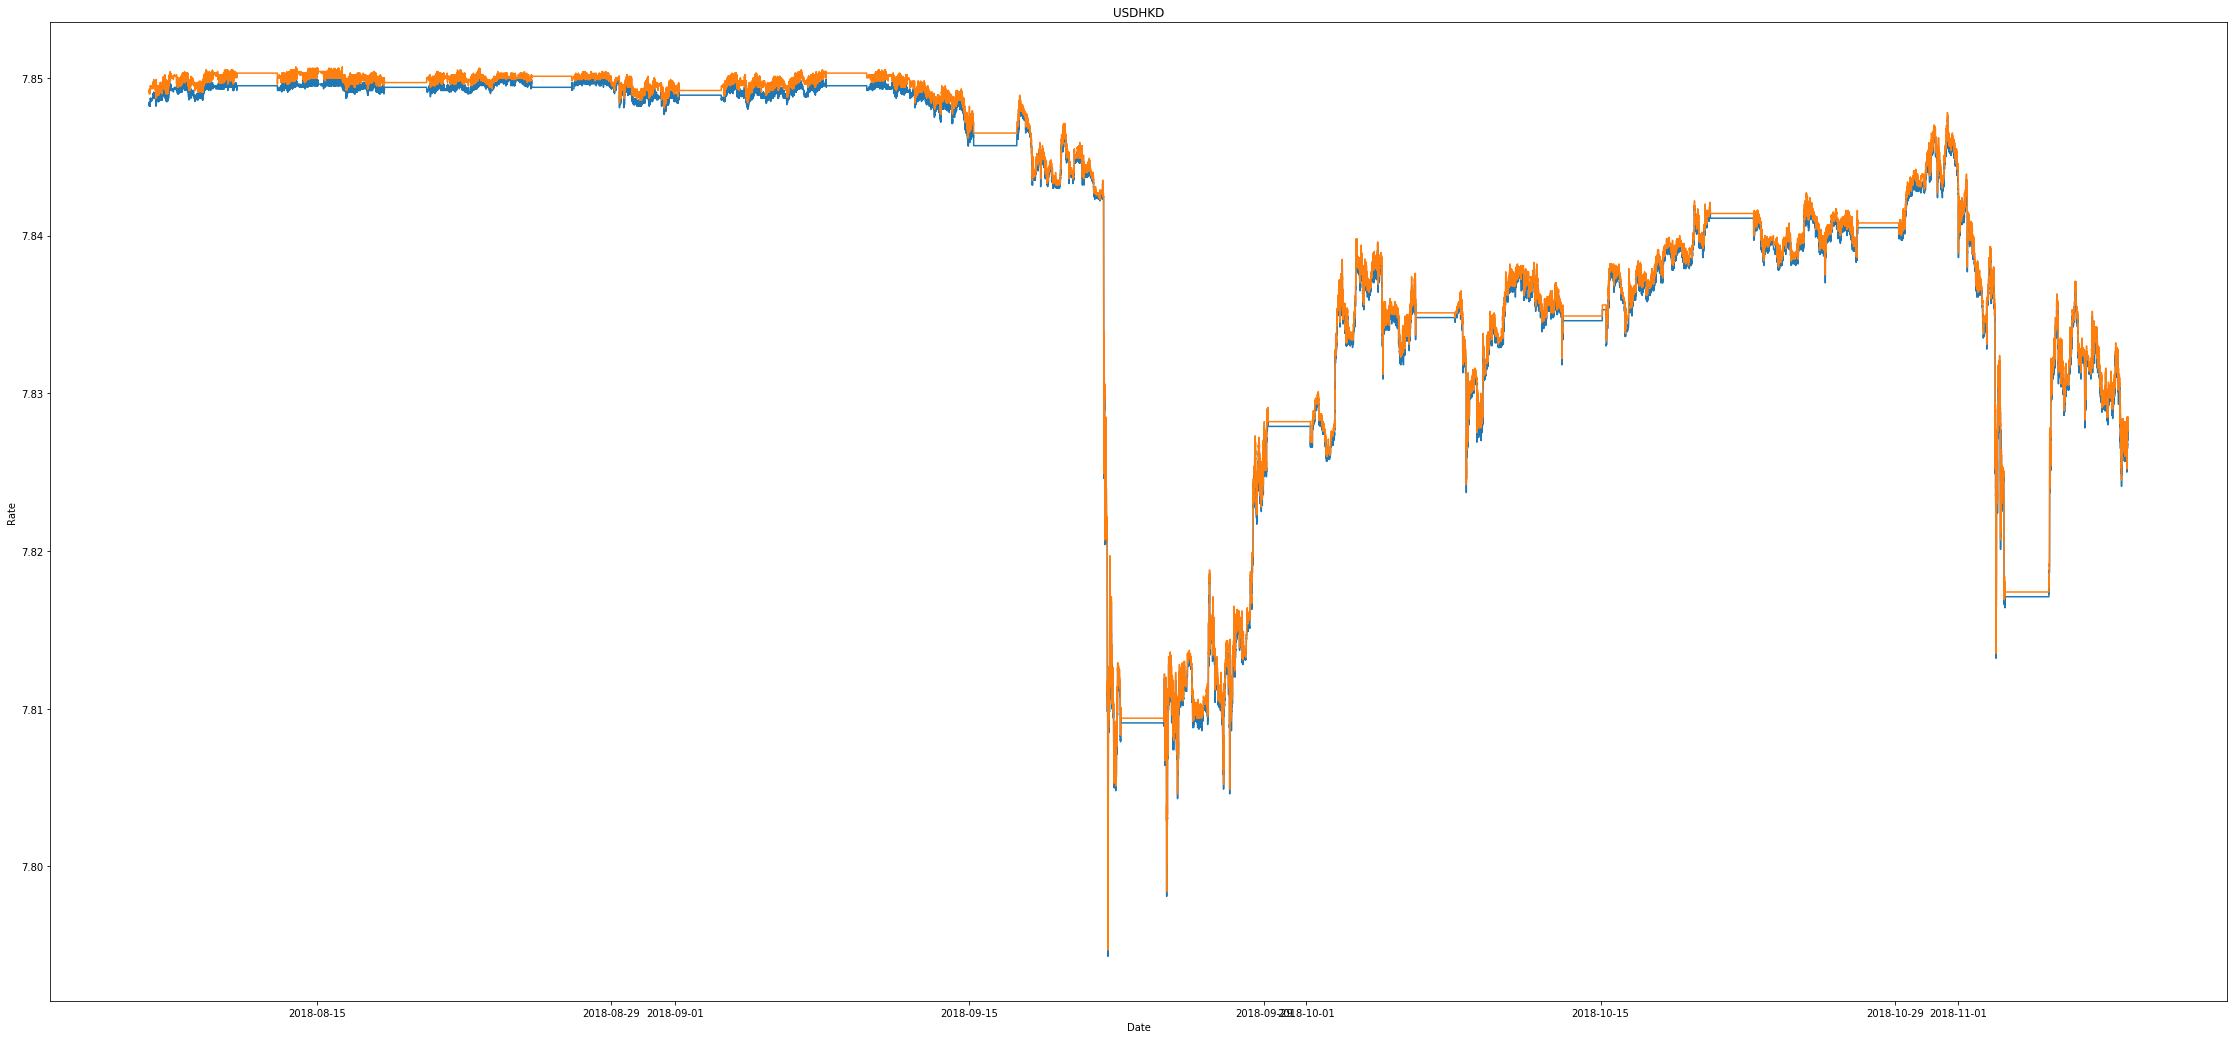

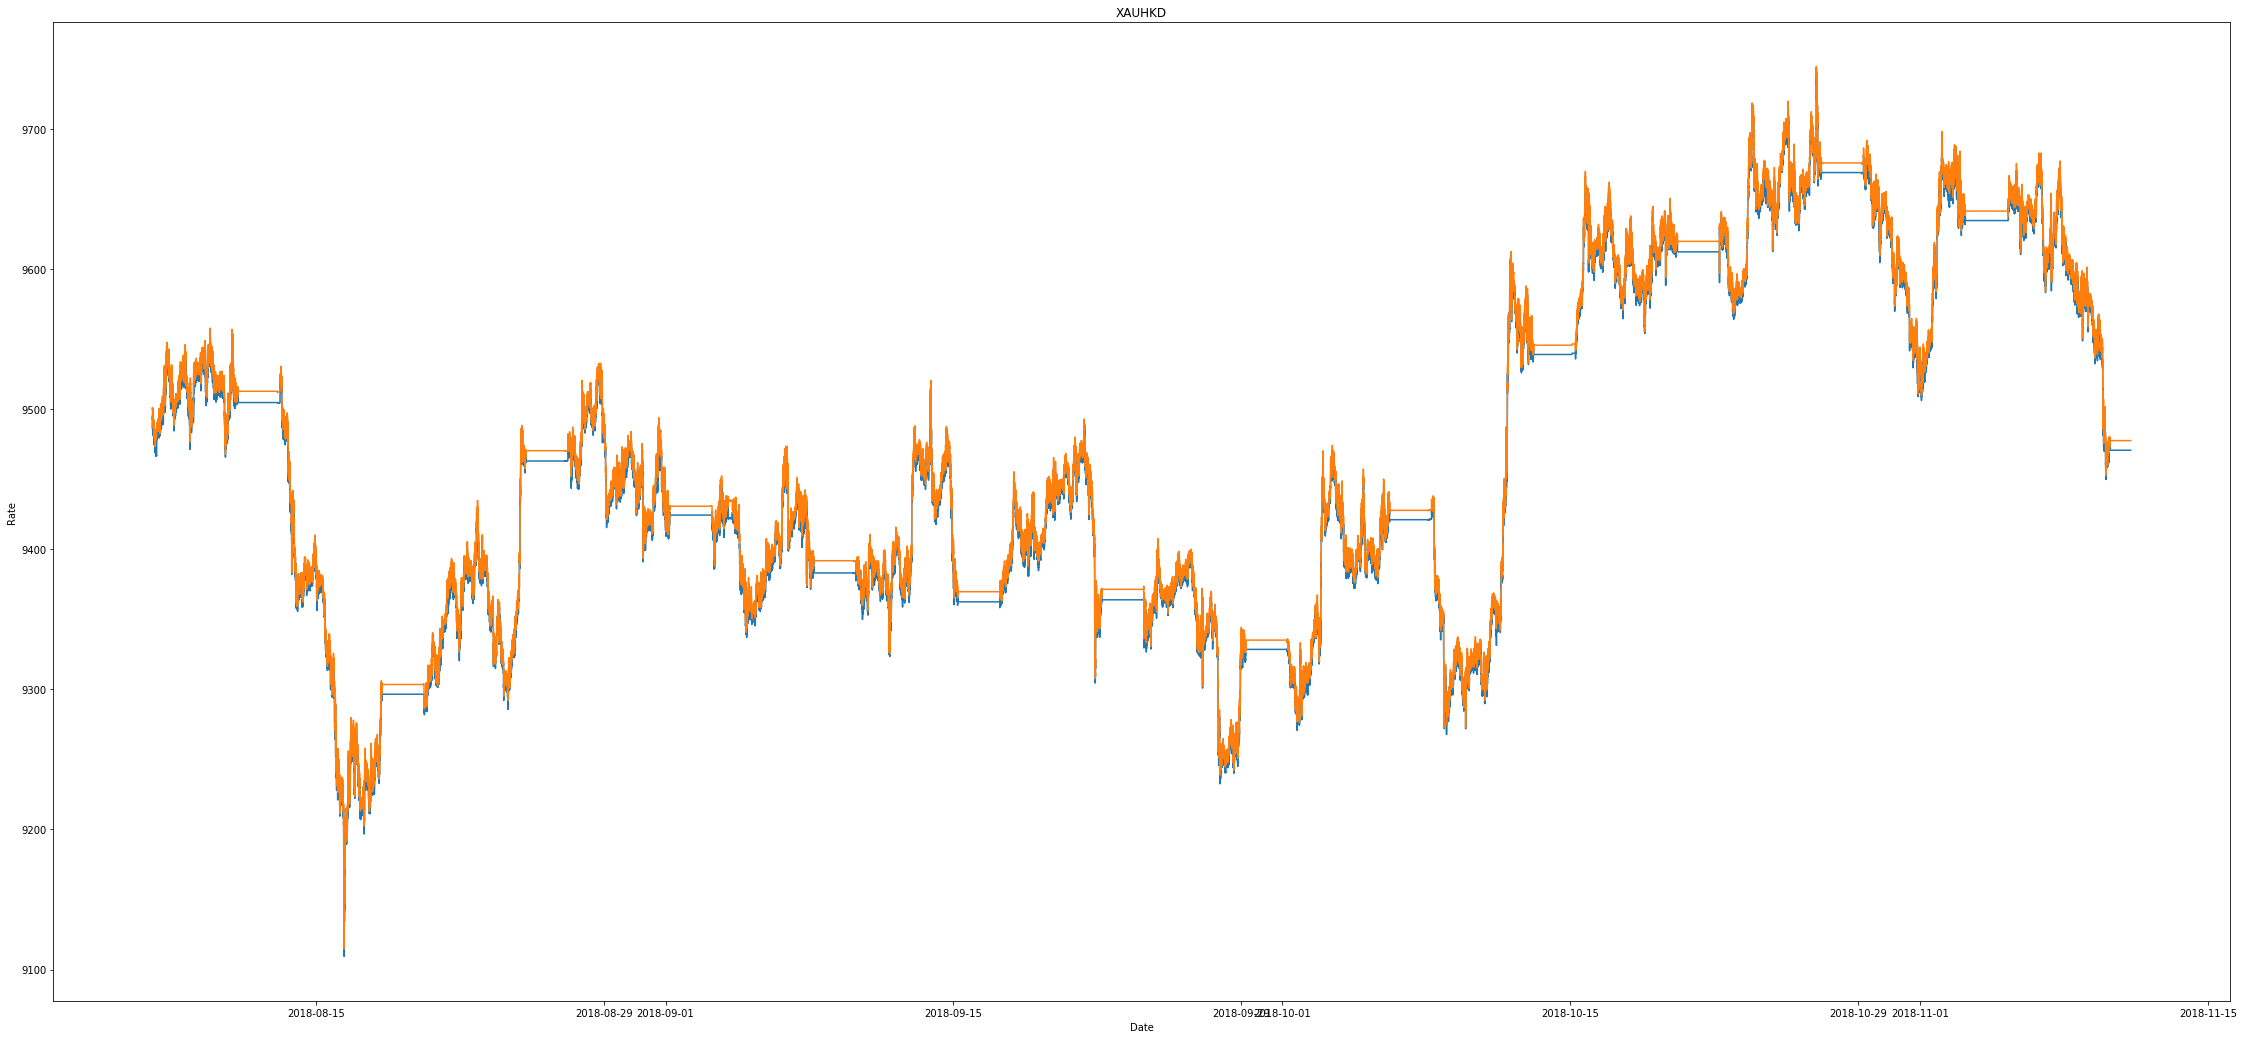

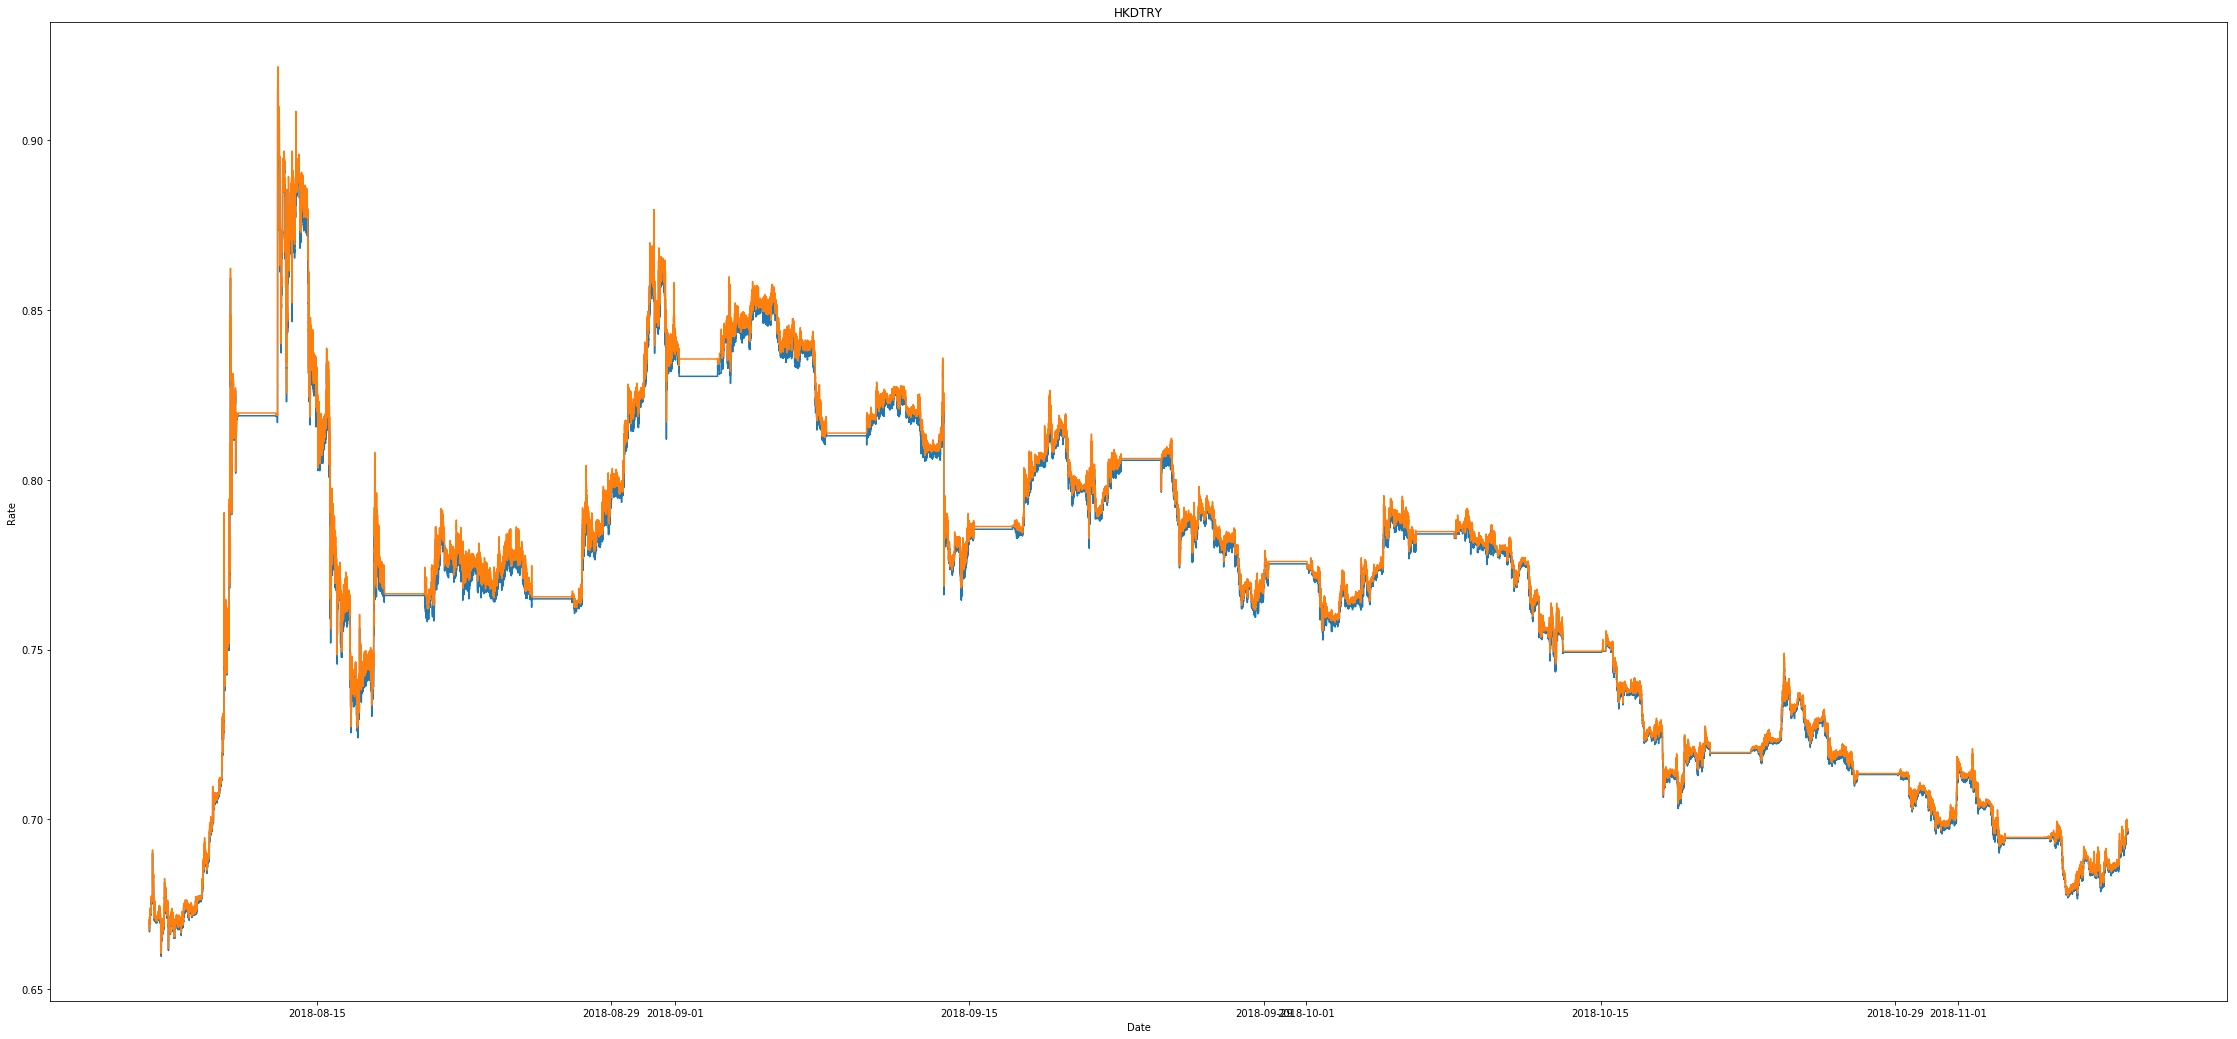

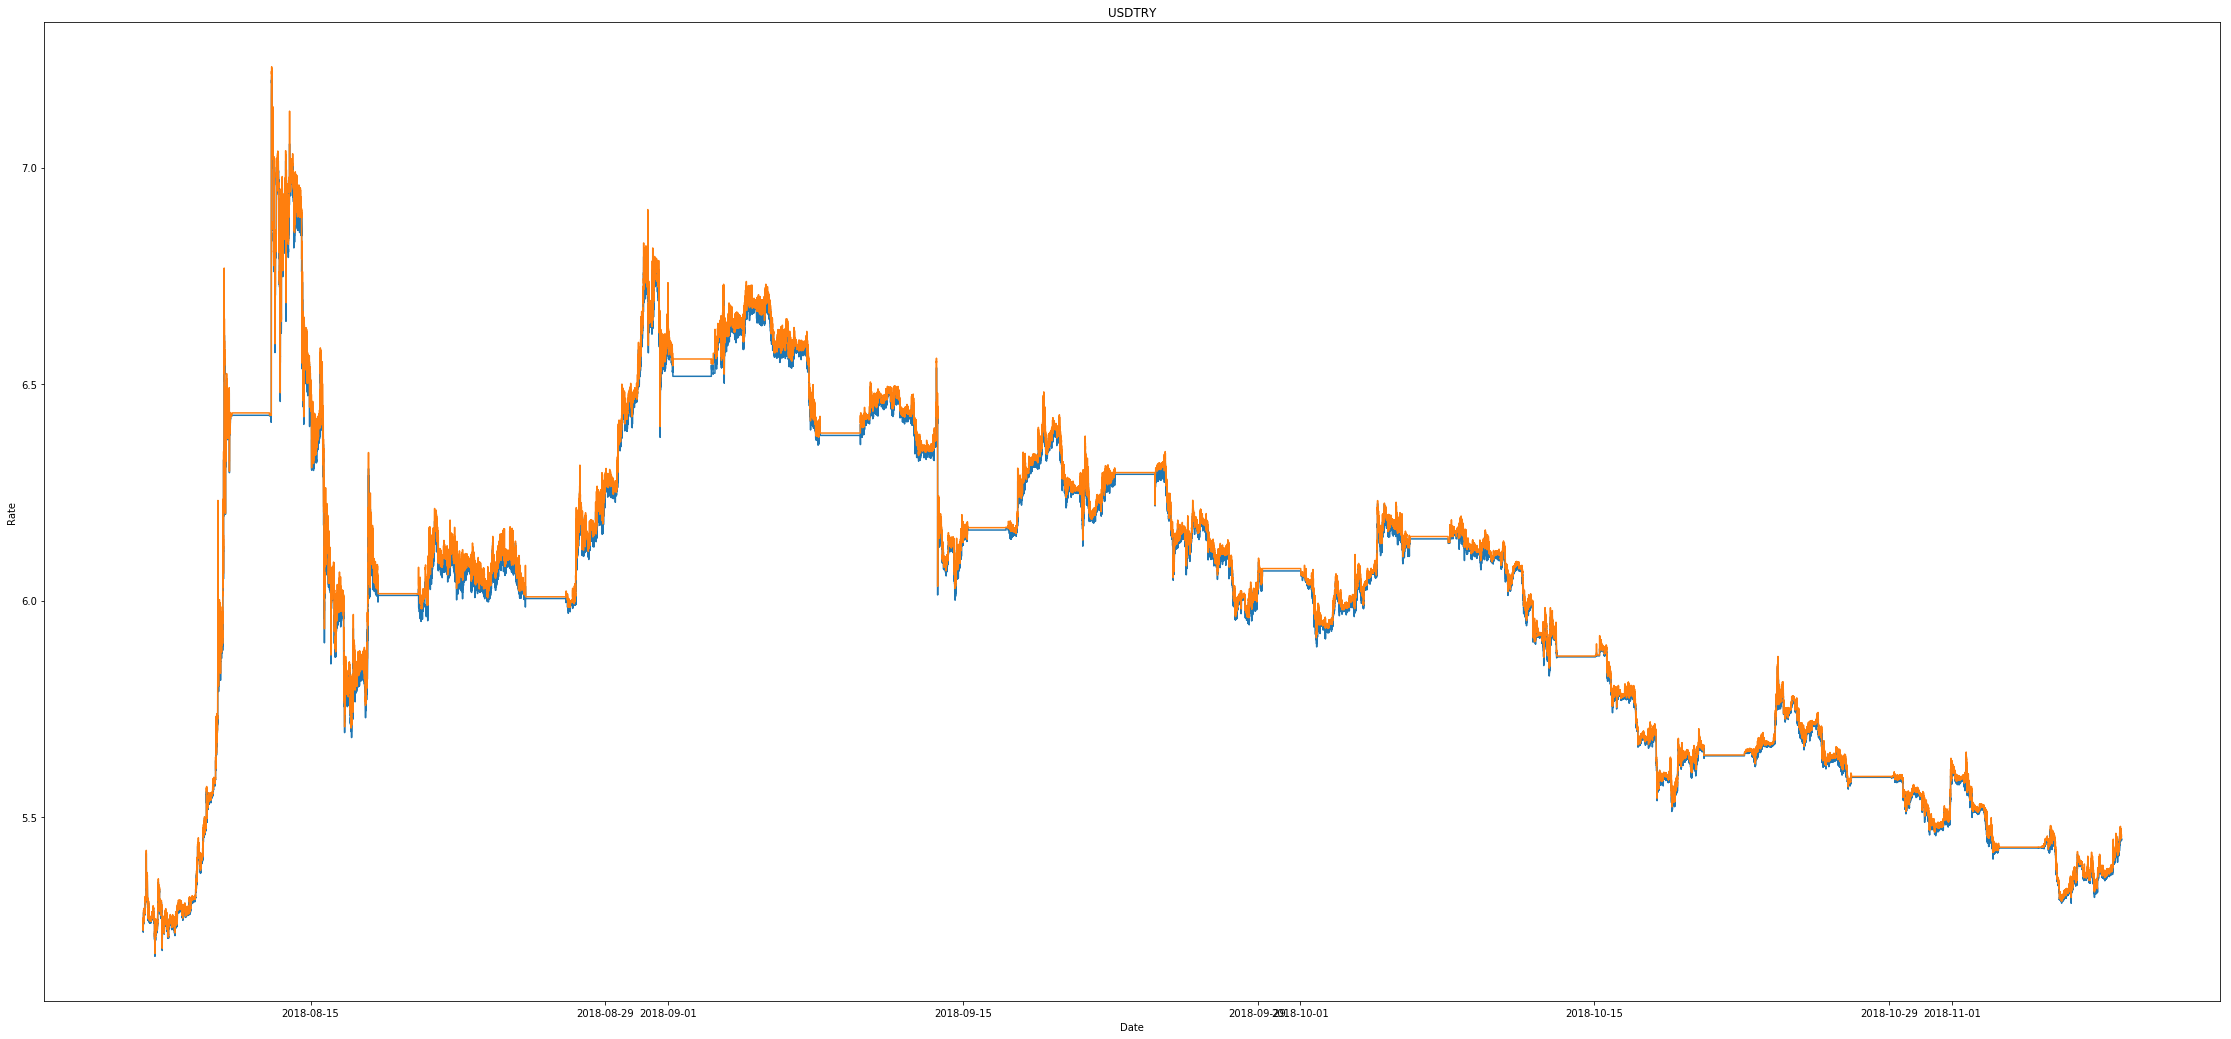

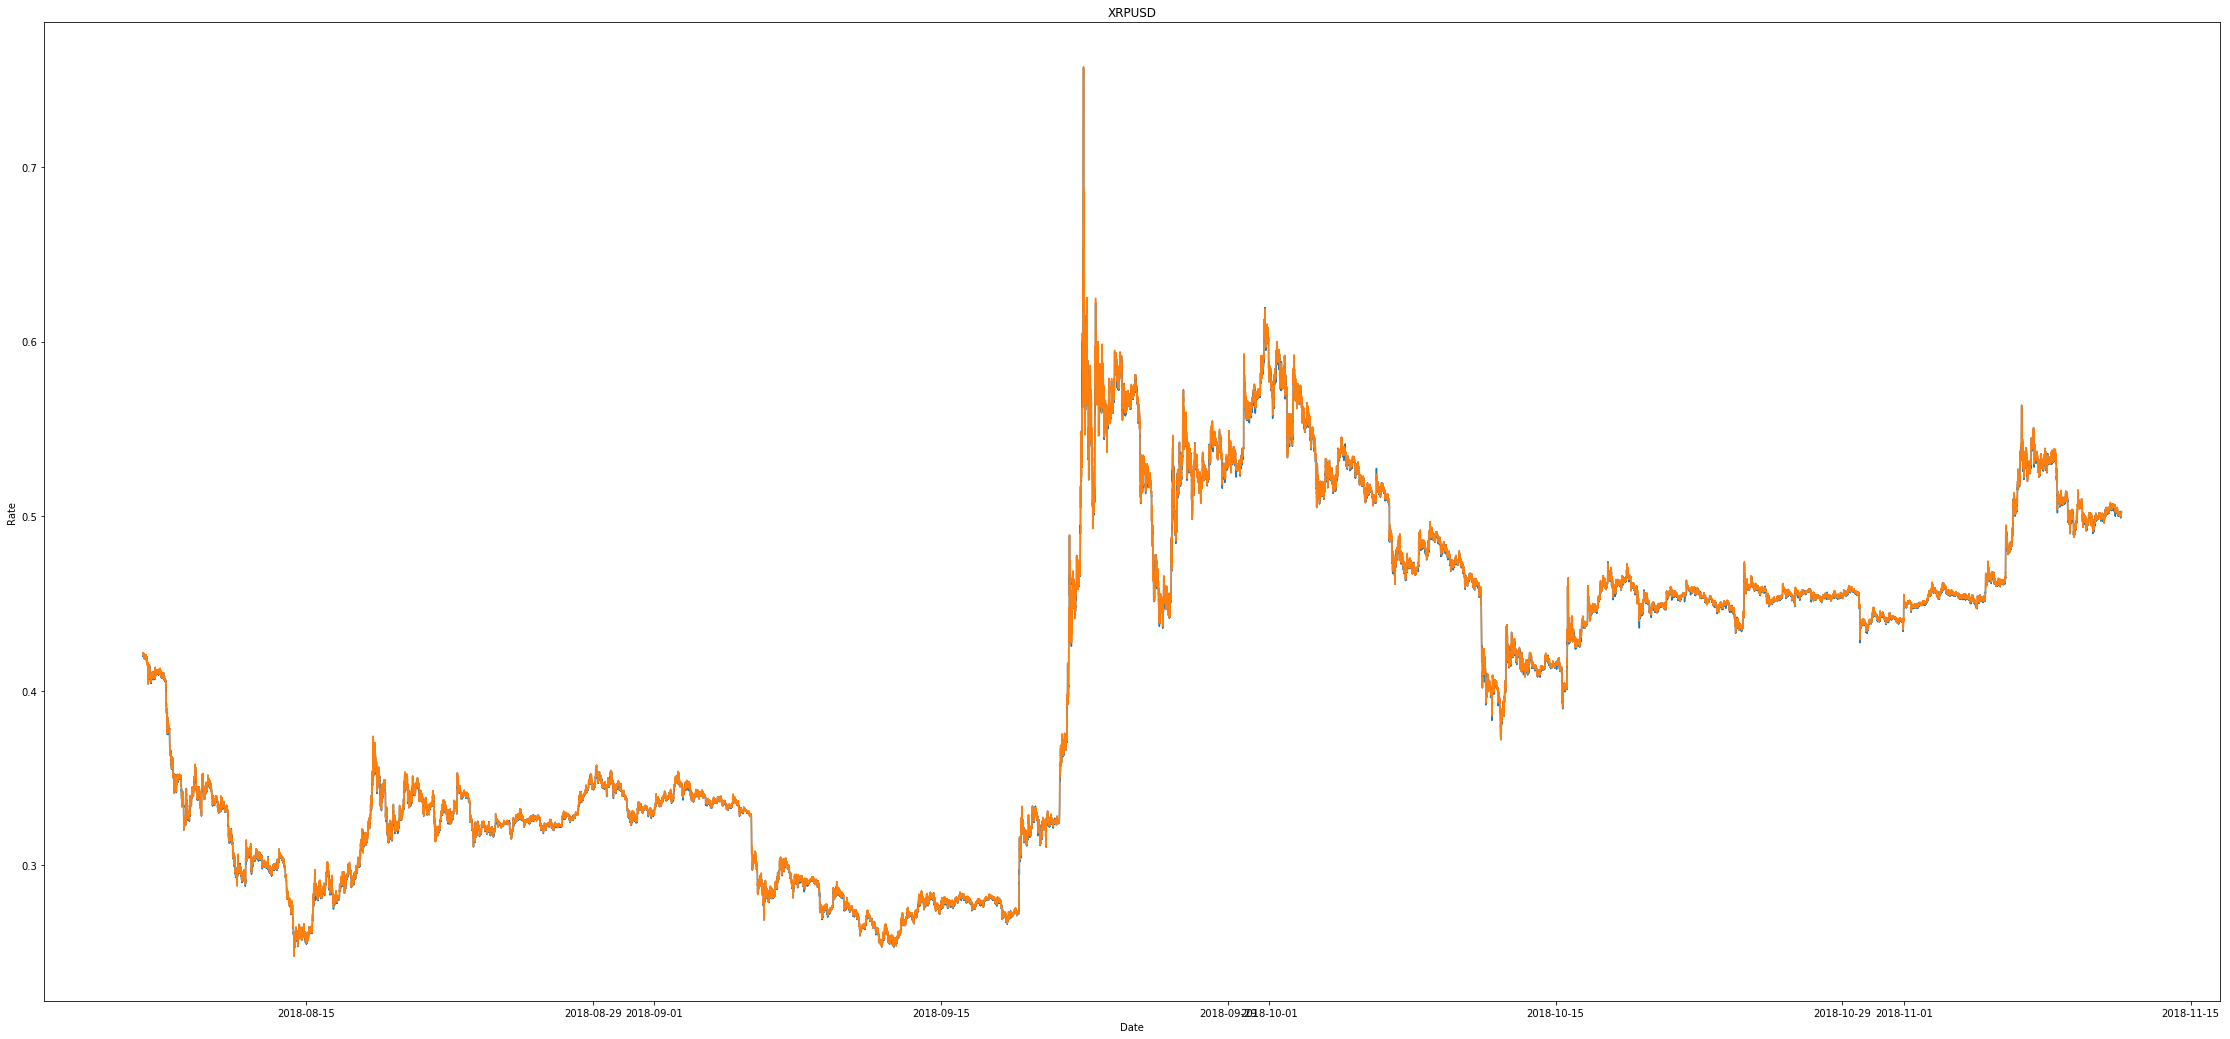

Activities:
   Product Position  Open Rate Close Rate      P&L
0      HSI    SHORT    27836.0    26835.0  99900.0
1     CALL     LONG      757.4          0   1532.0
2      PUT    SHORT      365.1          0   7201.1
3      HSI    SHORT    26827.0    27189.0 -36400.0
4     CALL     LONG      683.8      920.8   4541.3
5      PUT    SHORT      289.8      162.3   2350.4
6      HSI    SHORT    27175.0    26544.0  62900.0
7     CALL     LONG      767.8          0   7383.4
8      PUT    SHORT      223.3          0   4365.8
9      HSI    SHORT    26568.0    25758.0  80800.0
10    CALL     LONG      874.1      359.4 -10493.8
11     PUT    SHORT      359.7      638.9  -5784.4
12     HSI    SHORT    25753.0    24695.0 105600.0
13    CALL     LONG      780.1       79.7 -14207.0
14     PUT    SHORT      264.6      595.8  -6823.8
15     HSI    SHORT    24638.0    24536.0  10000.0
16    CALL     LONG      523.2      421.8  -2227.3
17     PUT    SHORT       96.3       94.1   -156.8
18     HSI    SHORT

In [6]:
from pylab import *
rcParams['figure.figsize'] = (39, 18)
#%% Export Portfolio 
tradelog = None
portfolio, tradelog = platform.exporttrades()
for i in range(len(tradelog)): 
    tradelog.loc[i, 'P&L'] = tradelog.loc[i, 'Unrealized P&L'] + tradelog.loc[i, 'Realized P&L']
print ('Activities:')
print (tradelog[['Product', 'Position', 'Open Rate', 'Close Rate', 'P&L']])
print ('Summary:')
print ('Initial Cash:', round(portfolio['initial']), 'Final Cash:', round(portfolio['cash']))
print ('Unrealized P&L:', round(portfolio['Unrealized P&L']), 'Realized P&L:', round(portfolio['Realized P&L']))
print ('Overall P&L:', round(portfolio['P&L']), 'P&L%:', round(portfolio['P&L%']))